<a href="https://colab.research.google.com/github/XinjianOUYANG/UNet-for-tumor-segmentation/blob/master/U_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Session: Tumor Segmentation with U-nets


## Problem Description


In medical diagnosis, it is of great value to identify tumor's posiion and size by CT image, which could further help the doctor to judge if the tumor transfer happens or not. This practical session aims to segment the tumor area from existing CT images with the help of U-nets. 

Here is a graph to help you understand better: the photo in the left is the original CT image, the photo in the right is the tumor area hand-written by the doctor. 

The segmentation requirements are:


*   segment the tumor area as accurate as possible;
*   The no-tumor area in the CT image should be presented as **black**;

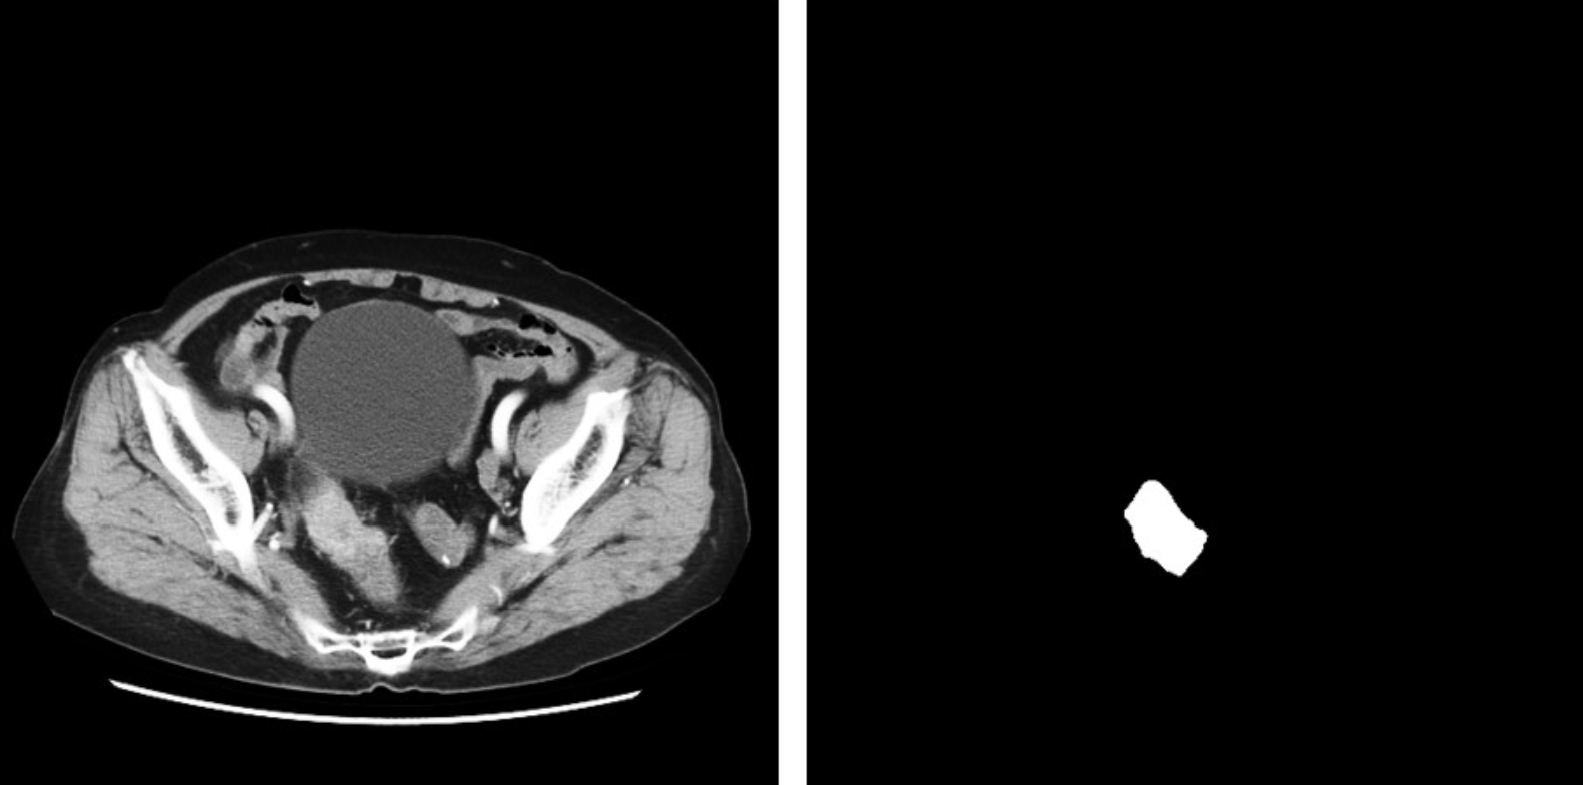



## U-Nets introduction


As presented in the 5-minutes video, U-Nets is a specific fully convolutional network (FCN), which consists of a contracting path and an expansive path as shown in the graph. U-net is widely used for fast and precise segmentation of images thanks to its special structure. 

If you forget our video presentation, don't worry. This link would provide you with further explanation about [U-Nets](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

![picture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

## Basic Process

This practical session follows a typical deep learning processus:

*   Data Preprocessing;
*   Network Construction;
*   Compiling Network;
*   Training Network;
*   Test and Evaluation;

### Data Preprocessing

* Data preprocessing includes following operations: 

  loading images --> cropping valid areas --> image normalisation --> seperating traing set and testing set(9:1 in size), and finally saving datasets.


* dataset introduction:

    We have the [CT images in github](https://github.com/XinjianOUYANG/UNet-for-tumor-segmentation/tree/master/train) of 108 patients, and each patient has 20-30 images. Moreover, the location of tumor of each image is labelled in advance in [lable folder](https://github.com/XinjianOUYANG/UNet-for-tumor-segmentation/tree/master/label)(if no tumor, the image is labelled in black). 
    
* data cropping

    We cropped images in order to extract the areas where the tumor would happen and improve the traning speed.


The data is downloaded from a open [competition](http://www.tipdm.org/bdrace/tzjingsai/20181226/1544.html) in China

### Network Construction

Based on the acknowledge about U-Nets, we construct a U-Nets network under the *keras* package in the environment *tensorflow*. 

#### Convolutional Block
Firstly, we will define a convulitonal function which would be used repeatedly. The general structure is: 

convolutional layer -> standardization layer -> activation function -> convolutional layer -> standardization layer -> activation function -> return result

In [ ]:
def conv2d_block(input_tensor, n_filters=16, kernel_size=3, batchnorm=True, padding='same'):
    # the first layer
    x = Conv2D(n_filters, kernel_size, padding=padding)(
        input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x) # relu activation function

    # the second layer
    x = Conv2D(n_filters, kernel_size, padding=padding)(x)
    if batchnorm:
        x = BatchNormalization()(x)
    X = Activation('relu')(x)
    return X

#### Contracting Path
As shown in the structure graph of U-Nets, the main process of the contracting path is:

Input image file -> 1 (convolutional block -> Max Pooling layer -> Dropout layer) -> 2  (convolutional block -> Max Pooling layer -> Dropout layer) -> 3 (convolutional block -> Max Pooling layer -> Dropout layer) -> 4 (convolutional block -> Max Pooling layer -> Dropout layer)

Logically, the code is shown below:

In [ ]:
# Construct an input
img = Input(shape=self.shape) # self.shape refers to the dimension of the image

# contracting path
c1 = conv2d_block(img, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
p1 = MaxPooling2D((2, 2))(c1)
p1 = Dropout(dropout * 0.5)(p1)

c2 = conv2d_block(p1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
p2 = MaxPooling2D((2, 2))(c2)
p2 = Dropout(dropout)(p2)

c3 = conv2d_block(p2, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)
p3 = MaxPooling2D((2, 2))(c3)
p3 = Dropout(dropout)(p3)

c4 = conv2d_block(p3, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)
p4 = MaxPooling2D((2, 2))(c4)
p4 = Dropout(dropout)(p4)

We finish the contracting path and get a medium layer:

In [ ]:
c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm, padding=padding)

#### Expanding Path
Similarly, the procedure of the expanding path is: 

Input from last layer -> 6 (upsampling -> caracteristics combination -> dropout layer -> convolutional block) -> 7 (upsampling -> caracteristics combination -> dropout layer -> convolutional block) -> 8 (upsampling -> caracteristics combination -> dropout layer -> convolutional block) -> 9 (upsampling -> caracteristics combination -> dropout layer -> convolutional block).



In [ ]:
# extending path
u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = Dropout(dropout)(u6)
c6 = conv2d_block(u6, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)

u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
u7 = Dropout(dropout)(u7)
c7 = conv2d_block(u7, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)

u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)

u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)

#### Output Layer


In [ ]:
output = Con2D(1,(1,1), activation = 'sigmoid')(c9)

return Model(img, output)

### Compiling Network

Here we compile the U-net by setting its basic parameters such as the optimiser, learning rate, loss function and evoluation function.

In [ ]:
class U_Net():
    def __init__(self):
        # set the basic parameters of an image
        self.height = 256
        self.width = 256
        self.channels = 1
        self.shape = (self.height, self.width, self.channels)
        # create a u-net
        self.unet = self.build_unet()  
        # set Adam as optimizer
        optimizer = Adam(0.002, 0.5)
        # u_net
        self.unet.compile(loss='mse',
                          optimizer=optimizer,
                          metrics=[self.metric_fun]) # evaluation function
        self.unet.summary()
    
    # use Dice coefficient to evaluation the quality of trained model
    def metric_fun(self, y_true, y_pred):
        fz = tf.reduce_sum(2 * y_true * tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-8
        fm = tf.reduce_sum(y_true + tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-8
        return fz / fm

In our U-net, we use Adam optimiser, MSE(Mean Squared Error) loss function and [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), which is often used to evaluate the quality of picture segmentation.

**Dice coeffient formula**:![Dice](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

### Training Network

### Test and Evaluation


## Little Quiz 

### Question 1:
Why does it exist expansive methods (the grey arrows in the structure graph of U-Nets)? 

### Question 2:
Why is U-Nets method suitable for medicla iamge segmentation? What kinds of caracteristics dedermine? 

### Question 3:
Fill in the three *code tasks* above. 